# KERNEL

In [9]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #3D plotting
from matplotlib import cm
from numpy.linalg import norm # For calculating vector norms (Euclidean distance)
import numpy as np

from genham import hammersley
 


### kernel.py

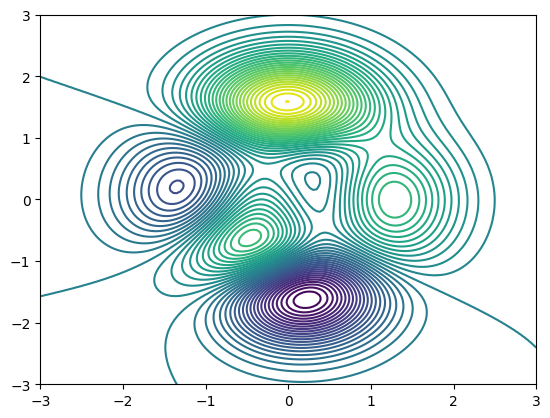

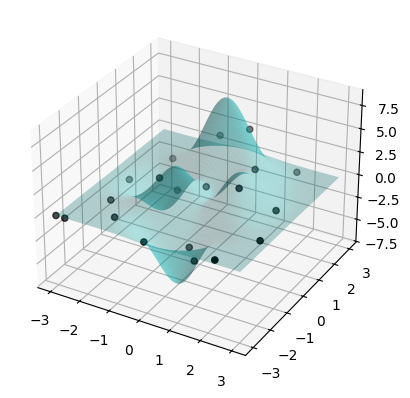

In [ ]:
# Define the "peaks" function, a complex surface that we want to model.
# This serves as the ground truth. 

def peaks(x,y):
    """
    Creates a bumpy surface used for testing interpolation/approximation.
    Inputs:
      x, y : scalars or numpy arrays 
    Returns:
      z : same shape as x/y
    """
    z =  (3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) 
          - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2)
          - 1/3 * np.exp(-(x+1)**2 - y**2)) 
    return(z)

# Generate training data
n = 20 # set the number of traning points

# Generate n training data points (x) in a 2D space from [-3, 3] x [-3, 3].
# hammersley() creates a quasi-random, evenly spaced set of points.
x = -3 + 6*hammersley([2,3],n) 

# Calculate the true output values (z) for our training points using the peaks function.
# x is our feature matrix, z is our target vector.
z = peaks(x[:,0],x[:,1]) 

# A grid for plotting the true surface
xx, yy = np.mgrid[-3:3:150j,-3:3:150j]
zz = peaks(xx,yy)

# Plot contours and surface with training points
plt.contour(xx,yy,zz,levels=50)

# Create a 3D plot to visualize the true surface and our training points.
fig=plt.figure()
ax = fig.add_subplot(111,projection='3d')

# Plot the "peaks" surface as a semi-transparent cyan mesh.
ax.plot_surface(xx,yy,zz,rstride=1,cstride=1,color='c',alpha=0.3,linewidth=0)

# Scatter plot the n training points (x, z) on top of the surface.
ax.scatter(x[:,0],x[:,1],z,color='k',s=20)
plt.show()



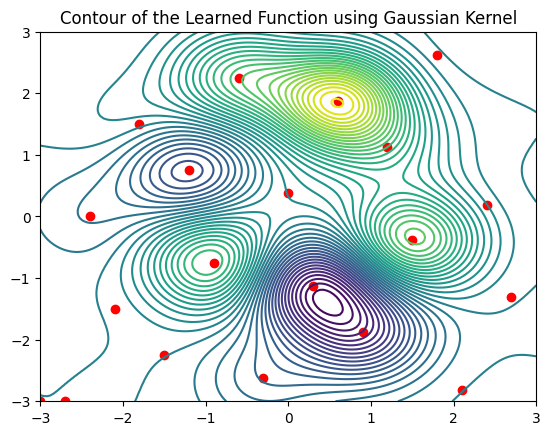

In [ ]:
# Kernel regression training
def kernel_train(k, n, x, y):
    """
    Trains the kernel model by finding the optimal weights 'alpha'.
    k: The kernel function.
    n: Number of training points.
    x: The training input data (n x d matrix).
    y: The training target data (n x 1 vector).
    """
    # Initialize an n x n matrix K, which will be the Gram matrix.
    K = np.zeros((n,n))

    # Populate the Gram matrix.
    for i in range(n):
        for j in range(n):
            # K[i,j] stores the similarity between training point i and training point j.
            K[i,j] = k(x[i,:],x[j])
    
    # Solve for alpha (dual weights)
    alpha = np.linalg.solve(K@K.T, K@y)
    return K, alpha

# Gaussian kernel
sig2 = 0.3 # kernel parameter (bandwidth). Controls the width of the kernel

def k(x,u):
   # Computes the similarity between two vectors x and u.
   return(np.exp(-0.5*norm(x- u)**2/sig2))

# Train the model using our data (x, z) and the Gaussian kernel k.
K, alpha = kernel_train(k, n, x, z)


# Prediction on grid

# Get the total number of points in our plotting grid.
N, = xx.flatten().shape

# Create a matrix to store the kernel evaluations between the n training
# points and the N grid points. Shape will be (n, N).

Kx = np.zeros((n,N))

# Populate the Kx matrix.
for i in range(n):
    # Calculate similarity between the i-th training point and the j-th grid point.
    for j in range(N):
        Kx[i,j] = k(x[i,:],np.array([xx.flatten()[j],yy.flatten()[j]]))
    

g = Kx.T @ alpha

# Reshape the flat prediction vector 'g' back into a 2D grid for plotting.
dim = np.sqrt(N).astype(int)
yhat = g.reshape((dim,dim))

# Plot contour of predicted function
plt.contour(xx,yy,yhat,levels=50)

plt.title("Contour of the Learned Function using Gaussian Kernel")
# Overlay the original training points to see how the function fits them.
plt.scatter(x[:,0], x[:,1], c='red')
plt.show()

### What is the matrix K

The matrix K is the Gram matrix,a fundamental component of kernel methods. It encodes the similarity between every possible pair of training data points, as defined by the chosen kernel function. 
It's an n x n square matrix where n is the number of training samples.

### What is the role of the kernel function k, and of the training set x in this algorithm? How does it relate to the theory presented in the videos?

The kernel function k defines similarity in feature space (linear, polynomial, Gaussian…).

The training set x anchors the function — predictions are linear combinations of similarities between new points and training points.

The final learned function is not defined by a simple parametric form (like y = mx + c), but rather as a weighted sum of influences from these specific training points.

### How could one plot the final trained function? 

To plot the final trained function, 

- Create a grid of points (xx, yy) over the domain you want to visualize. For each point in this grid, calculate its kernel similarity to all of the original training points then use the learned weights to compute the predicted value for each grid point. The resulting prediction vector can be reshaped into the shape of the grid and use a plotting function ( plt.contour or ax.plot_surface. )

### How could one test the resulting function on a novel test set? 

You go through a similar process, calculate the kernel values between the new test points and the training points, then multiply by the learned weights. This gives the predicted outputs for the unseen test inputs.


### Investigate the Gram matrix corresponding to different kernel functions (include the straight-up linear kernel, a polynomial feature kernel and the Gaussian mixture) and training sets. What do you notice? What does this mean for transposing it in the various parts of the algorithm?

Different Kernels:

    Linear Kernel: k(u, v) = np.dot(u, v)

    Polynomial Kernel: k(u, v) = (c + np.dot(u, v))**d

    Gaussian (RBF) Kernel: k(u, v) = np.exp(-gamma * norm(u-v)**2)

In [ ]:
# Kernels
def linear_kernel(u, v):
    return float(np.dot(u, v))

def polynomial_kernel(u, v, degree=3, c=1.0):
    return float((c + np.dot(u, v))**degree)

def rbf_kernel(u, v, sigma2=0.3):
    return float(np.exp(-0.5 * norm(u - v)**2 / sigma2))

#### Try polynomial feature maps of different orders. How does this compare with ordinary polynomial regression?  Explain with reference to both the theory on the course and what you see empirically. 